## 1. Data Preprocessing

In [52]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl

In [53]:
# 1. Prüfe das aktuelle Arbeitsverzeichnis
print("Aktuelles Verzeichnis:", Path.cwd())

csv_path = Path("/Users/ilyaskaracabey/Desktop/Enviroments/AIS/data/processed/ais/fehmarnbelt_ais_filtered.csv")

if not csv_path.exists():
    raise FileNotFoundError(f"Datei nicht gefunden: {csv_path}\n"
                            f"Bitte überprüfe Pfad und Arbeitsverzeichnis.")

Aktuelles Verzeichnis: /Users/ilyaskaracabey/Desktop/Enviroments/AIS


In [54]:
# 2. Sortieren und Δt berechnen
df = pd.read_csv(csv_path, parse_dates=["# Timestamp"])  # passe "Timestamp" ggf. an

df_sorted = df.sort_values(['MMSI', '# Timestamp'])
df_sorted['delta_t'] = df_sorted.groupby('MMSI')['# Timestamp'].diff().dt.total_seconds()

# 3. NaN entfernen und Kennzahlen
deltas = df_sorted['delta_t'].dropna()
print(deltas.describe())


count    58445.000000
mean         9.545248
std        169.139620
min          0.000000
25%          6.000000
50%          9.000000
75%         10.000000
max      40795.000000
Name: delta_t, dtype: float64


count    57833.000000
mean         8.698511
std          3.314834
min          1.000000
25%          6.000000
50%          9.000000
75%         10.000000
max         22.000000
Name: delta_t, dtype: float64


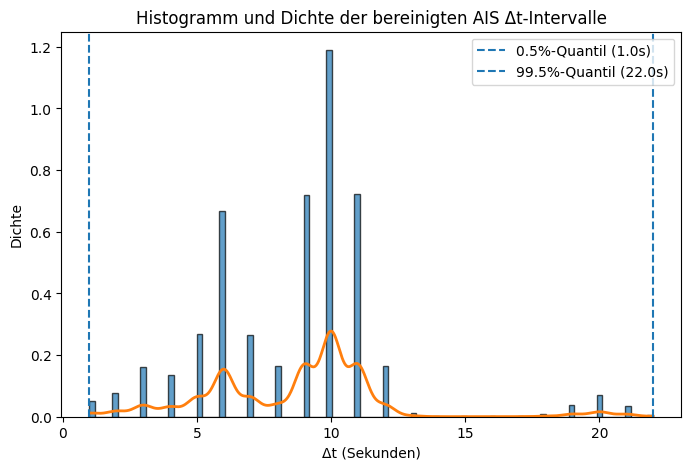

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 1. Aus vorherigen Schritten:
deltas_clean = deltas[deltas > 0]

# 2. Quantile berechnen und trimmen
q_low, q_high = deltas_clean.quantile([0.005, 0.995])
deltas_trimmed = deltas_clean[(deltas_clean >= q_low) & (deltas_clean <= q_high)]
print(deltas_trimmed.describe())

# 3. KDE-Dichte schätzen
kde = gaussian_kde(deltas_trimmed.values)
xs = np.linspace(deltas_trimmed.min(), deltas_trimmed.max(), 1000)

# 4. Plot: Histogramm + KDE + Cut-Off-Linien
plt.figure(figsize=(8, 5))
plt.hist(deltas_trimmed, bins=100, density=True, alpha=0.7, edgecolor='black')
plt.plot(xs, kde(xs), lw=2)

# Quantil-Grenzen markieren
plt.axvline(q_low, linestyle='--', linewidth=1.5,
            label=f'0.5%-Quantil ({q_low:.1f}s)')
plt.axvline(q_high, linestyle='--', linewidth=1.5,
            label=f'99.5%-Quantil ({q_high:.1f}s)')

plt.title('Histogramm und Dichte der bereinigten AIS Δt-Intervalle')
plt.xlabel('Δt (Sekunden)')
plt.ylabel('Dichte')
plt.legend()
plt.show()

In [34]:
# 1. Speichere die Ausgangsgröße
original_count = len(df_sorted)

# 2. Lege den Filter an
mask = (
    (df_sorted['delta_t'] > 0) &
    (df_sorted['delta_t'] >= q_low) &
    (df_sorted['delta_t'] <= q_high)
)

# 3. Filtere in ein neues DataFrame (ohne df_sorted zu überschreiben)
df_filtered = df_sorted.loc[mask].copy()

# 4. Vergleiche jetzt
print("Ursprüngliche Zeilen:", original_count)
print("Gefilterte Zeilen:  ", len(df_filtered))

Ursprüngliche Zeilen: 58515
Gefilterte Zeilen:   57833


## 2. GMM

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# 1. Daten für das GMM vorbereiten
#    df_filtered enthält nur die bereinigten Δt-Werte
X = df_filtered['delta_t'].values.reshape(-1, 1)

# 2. GMM initialisieren und fitten (3 Komponenten für deine 3 Peaks)
gmm = GaussianMixture(
    n_components=3,
    covariance_type='full',
    random_state=42
)
gmm.fit(X)

# 3. Parameter auslesen
means      = gmm.means_.flatten()       # Mittelpunkte der 3 Peaks
variances  = gmm.covariances_.flatten() # Varianzen der Peaks
weights    = gmm.weights_               # Mischgewichte
aic_value  = gmm.aic(X)
bic_value  = gmm.bic(X)

print("Komponenten-Mittelwerte (s):", np.round(means, 2))
print("Komponenten-Varianzen (s²):", np.round(variances, 2))
print("Mischgewichte:", np.round(weights, 3))
print("AIC:", np.round(aic_value, 1))
print("BIC:", np.round(bic_value, 1))


Komponenten-Mittelwerte (s): [ 5.54 10.11 19.9 ]
Komponenten-Varianzen (s²): [3.35 0.88 1.05]
Mischgewichte: [0.38  0.586 0.034]
AIC: 266659.5
BIC: 266731.2


## Anomalie Detektion

In [70]:
# 1. Log-Likelihoods berechnen
log_likelihoods = gmm.score_samples(X)  # X = df_filtered['delta_t'].values.reshape(-1,1)

# 2. Schwellenwert bestimmen
#    z.B. so, dass 1% der Trainingsdaten darunter liegen
tau = np.percentile(log_likelihoods, 1)

# 3. Indizes der Ausreißer
anomaly_idx = np.where(log_likelihoods < tau)[0]

# 4. Ausreißer markieren im DataFrame
df_filtered['gmm_loglik'] = log_likelihoods
df_filtered['anomaly']    = False
df_filtered.iloc[anomaly_idx, df_filtered.columns.get_loc('anomaly')] = True

print(f"Gefundene Anomalien (Likelihood < {tau:.2f}): {len(anomaly_idx)}")

Gefundene Anomalien (Likelihood < -5.56): 385


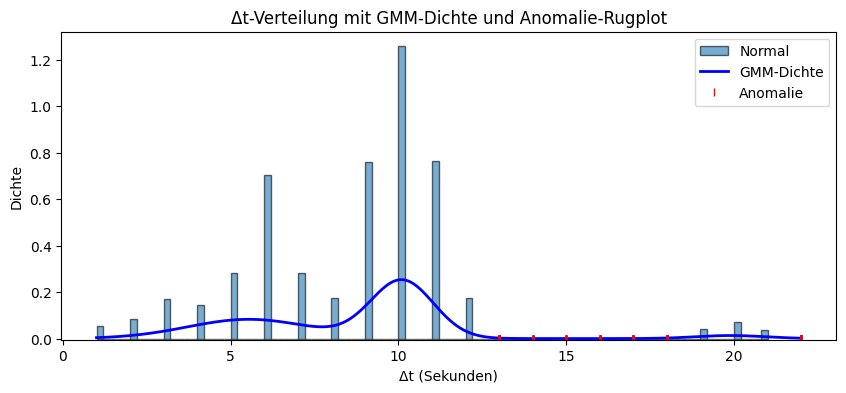

In [75]:
# 1. Normal- und Anomalie-Δt extrahieren
deltas_norm = df_filtered.loc[~df_filtered['anomaly'], 'delta_t']
deltas_ano  = df_filtered.loc[df_filtered['anomaly'],  'delta_t']
X = df_filtered['delta_t'].values.reshape(-1, 1)

# 2. GMM-Dichte berechnen
xs = np.linspace(X.min(), X.max(), 1000)
pdf = np.exp(gmm.score_samples(xs.reshape(-1, 1)))

# 3. Plot
plt.figure(figsize=(10, 4))
plt.hist(deltas_norm, bins=100, density=True,
         alpha=0.6, edgecolor='black', label='Normal')
plt.plot(xs, pdf, color='blue', lw=2, label='GMM-Dichte')
plt.plot(deltas_ano, np.full_like(deltas_ano, -0.002), '|',
         color='red', markeredgewidth=1, label='Anomalie')

plt.title('Δt-Verteilung mit GMM-Dichte und Anomalie-Rugplot')
plt.xlabel('Δt (Sekunden)')
plt.ylabel('Dichte')
plt.ylim(bottom=-0.005)
plt.legend()
plt.show()